Imports

In [1]:
%matplotlib inline

import dataLoader
import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
savedModelName = "grayscale"

image_path = "./Fish_toy/images"
training_count=2
validation_count=1
batchSize=10
n_epochs=1000
kernels = [16, 32]
kernelSize = 5
imgH = 28
n_channels = 1

Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Load images

In [4]:
import torchvision

# load images
dataset = dataLoader.FishDataset(image_path, imgH, n_channels, True)
numberOfSpecies = len(dataset.getSpeciesList())
print("Number of species = ", numberOfSpecies)

# get Loaders
train_loader, validation_loader, test_loader = dataLoader.getLoadersFromDataset(dataset, training_count, validation_count, batchSize)

Number of images =  117
0 Abudefduf vaigiensis  has  4  images
1 Pardachirus pavoninus  has  5  images
2 Wetmorella albofasciata  has  5  images
3 Zebrasoma scopas  has  5  images
4 Acanthurus achilles  has  5  images
5 Anampses caeruleopunctatus  has  5  images
6 Wetmorella nigropinnata  has  5  images
7 Variola albimarginata  has  4  images
8 Upeneus moluccensis  has  5  images
9 Xiphocheilus typus  has  4  images
10 Acanthurus coeruleus  has  5  images
11 Acanthopagrus pacificus  has  3  images
12 Ablabys taenianotus  has  5  images
13 Acanthurus chirurgus  has  5  images
14 Amphiprion clarkii  has  5  images
15 Xenisthmus polyzonatus  has  5  images
16 Acanthemblemaria spinosa  has  4  images
17 Acanthemblemaria aspera  has  5  images
18 Acanthurus bahianus  has  4  images
19 Anampses geographicus  has  5  images
20 Amphiprion polymnus  has  5  images
21 abudefduf septemfasciatus  has  4  images
22 Lepidozygus tapeinosoma  has  5  images
23 Xanthichthys auromarginatus  has  5  imag

Create/Load model

In [5]:
import os

model = CNN.CNN(numberOfSpecies, imgH, kernels, kernelSize, n_channels)

if os.path.exists(savedModelName):
    loss_list, accuracy_list = CNN.loadModel(model, savedModelName)
    print("Model {0} loaded!".format(savedModelName))
else:
    loss_list, accuracy_list = CNN.trainModel(train_loader, validation_loader, n_epochs, model, savedModelName)

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 0:11:09 Time:  0:11:09


Early stopping
total number of epochs:  120


Plot

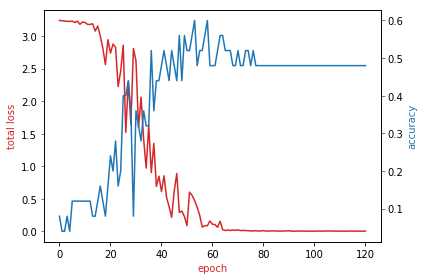

In [6]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

Create confusion matrix

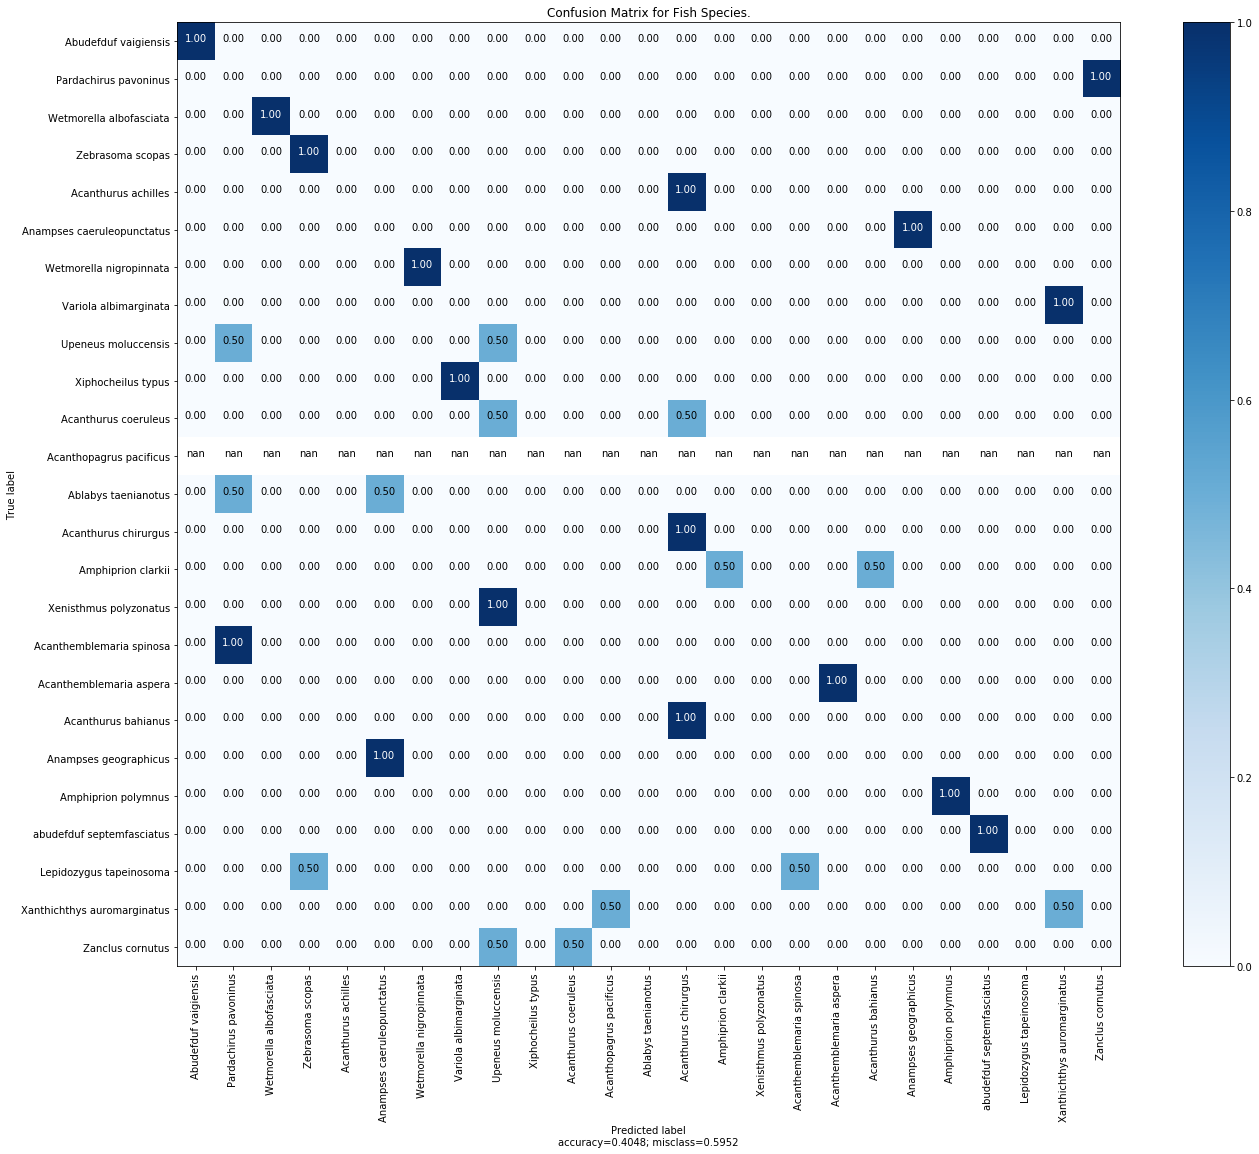

In [7]:
from sklearn.metrics import confusion_matrix
from confusion_matrix_plotter import plot_confusion_matrix2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0)
lbllist=torch.zeros(0)

with torch.no_grad():
    for batch in test_loader:
        inputs = batch["image"]
        classes = batch["class"]
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.float().view(-1)])
        lbllist=torch.cat([lbllist,classes.float().view(-1)])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.cpu().numpy(), predlist.cpu().numpy(), labels = range(numberOfSpecies))

plot_confusion_matrix2(conf_mat,
                          dataset.getSpeciesList(),
                          title='Confusion Matrix for Fish Species.')


Precision/Recall/Fscore

In [8]:
from sklearn.metrics import classification_report
print(classification_report(lbllist.cpu().numpy(), predlist.cpu().numpy(), labels = range(numberOfSpecies), digits=1))

              precision    recall  f1-score   support

           0        1.0       1.0       1.0         1
           1        0.0       0.0       0.0         2
           2        1.0       1.0       1.0         2
           3        0.7       1.0       0.8         2
           4        0.0       0.0       0.0         2
           5        0.0       0.0       0.0         2
           6        1.0       1.0       1.0         2
           7        0.0       0.0       0.0         1
           8        0.2       0.5       0.3         2
           9        0.0       0.0       0.0         1
          10        0.0       0.0       0.0         2
          11        0.0       0.0       0.0         0
          12        0.0       0.0       0.0         2
          13        0.3       1.0       0.5         2
          14        1.0       0.5       0.7         2
          15        0.0       0.0       0.0         2
          16        0.0       0.0       0.0         1
          17        1.0    

Plot parameters of first layer

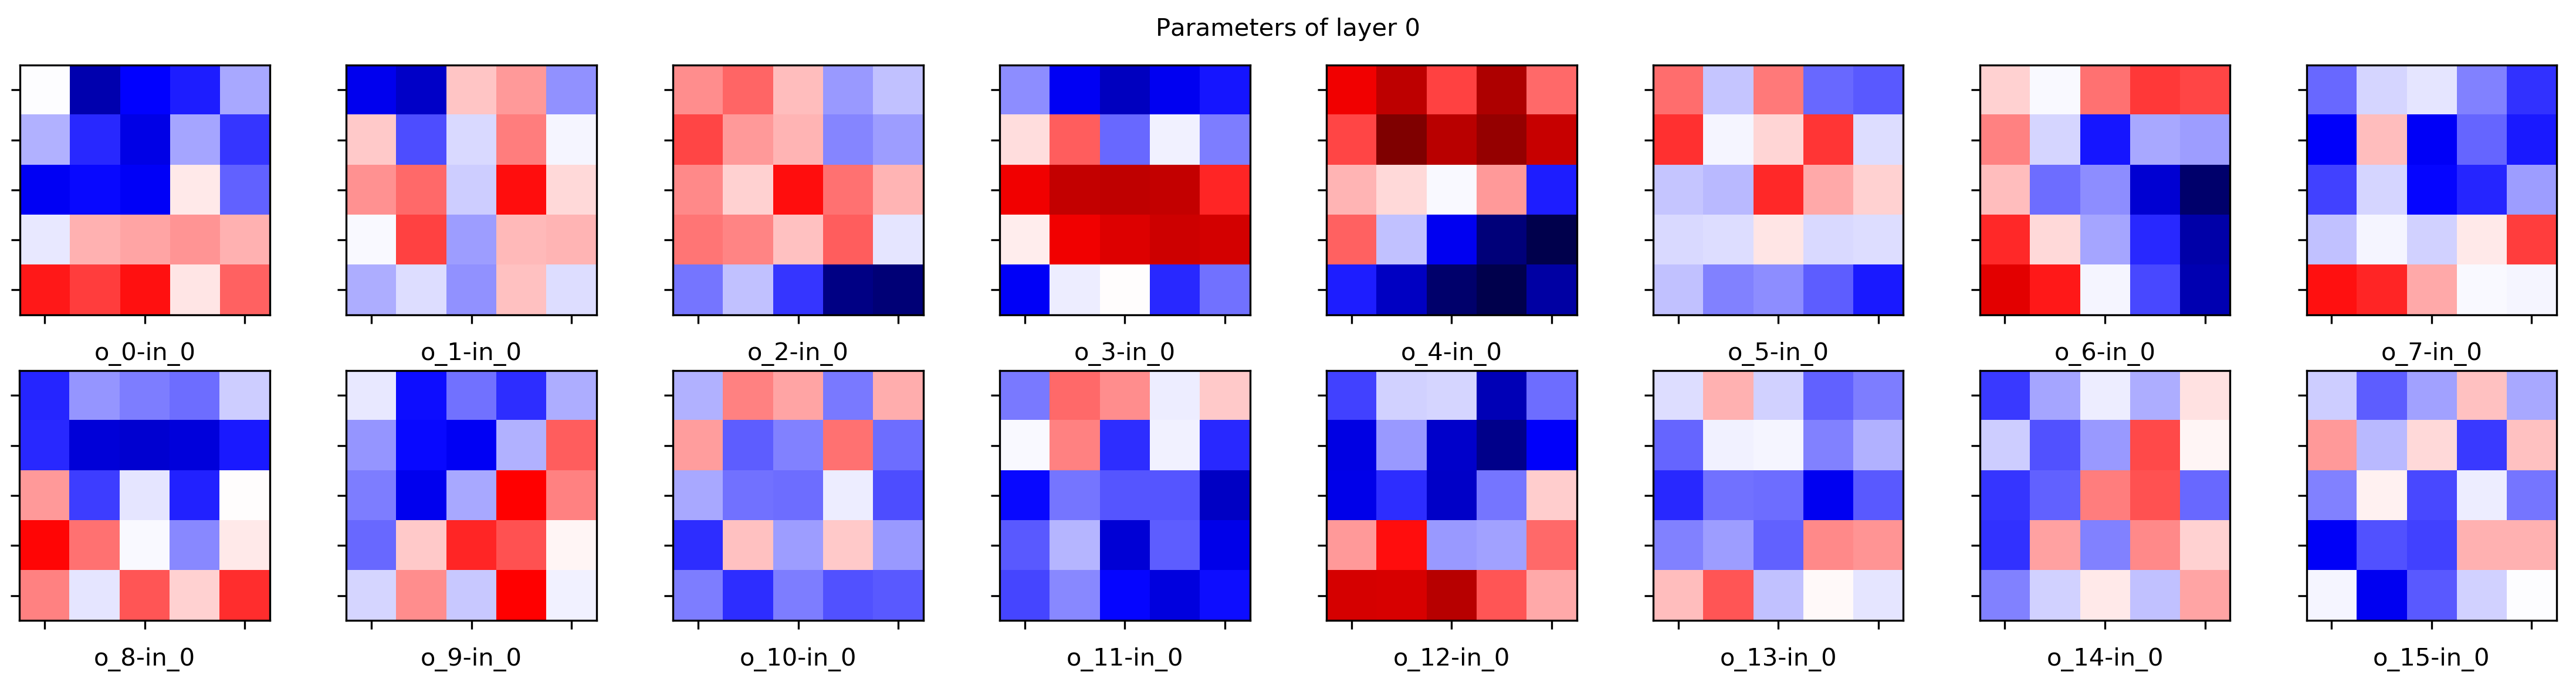

In [9]:
import PlotNetwork
PlotNetwork.plot_channels(model, 0)

Plot parameters of second layer

In [10]:
PlotNetwork.plot_channels(model, 1)

Plot activations

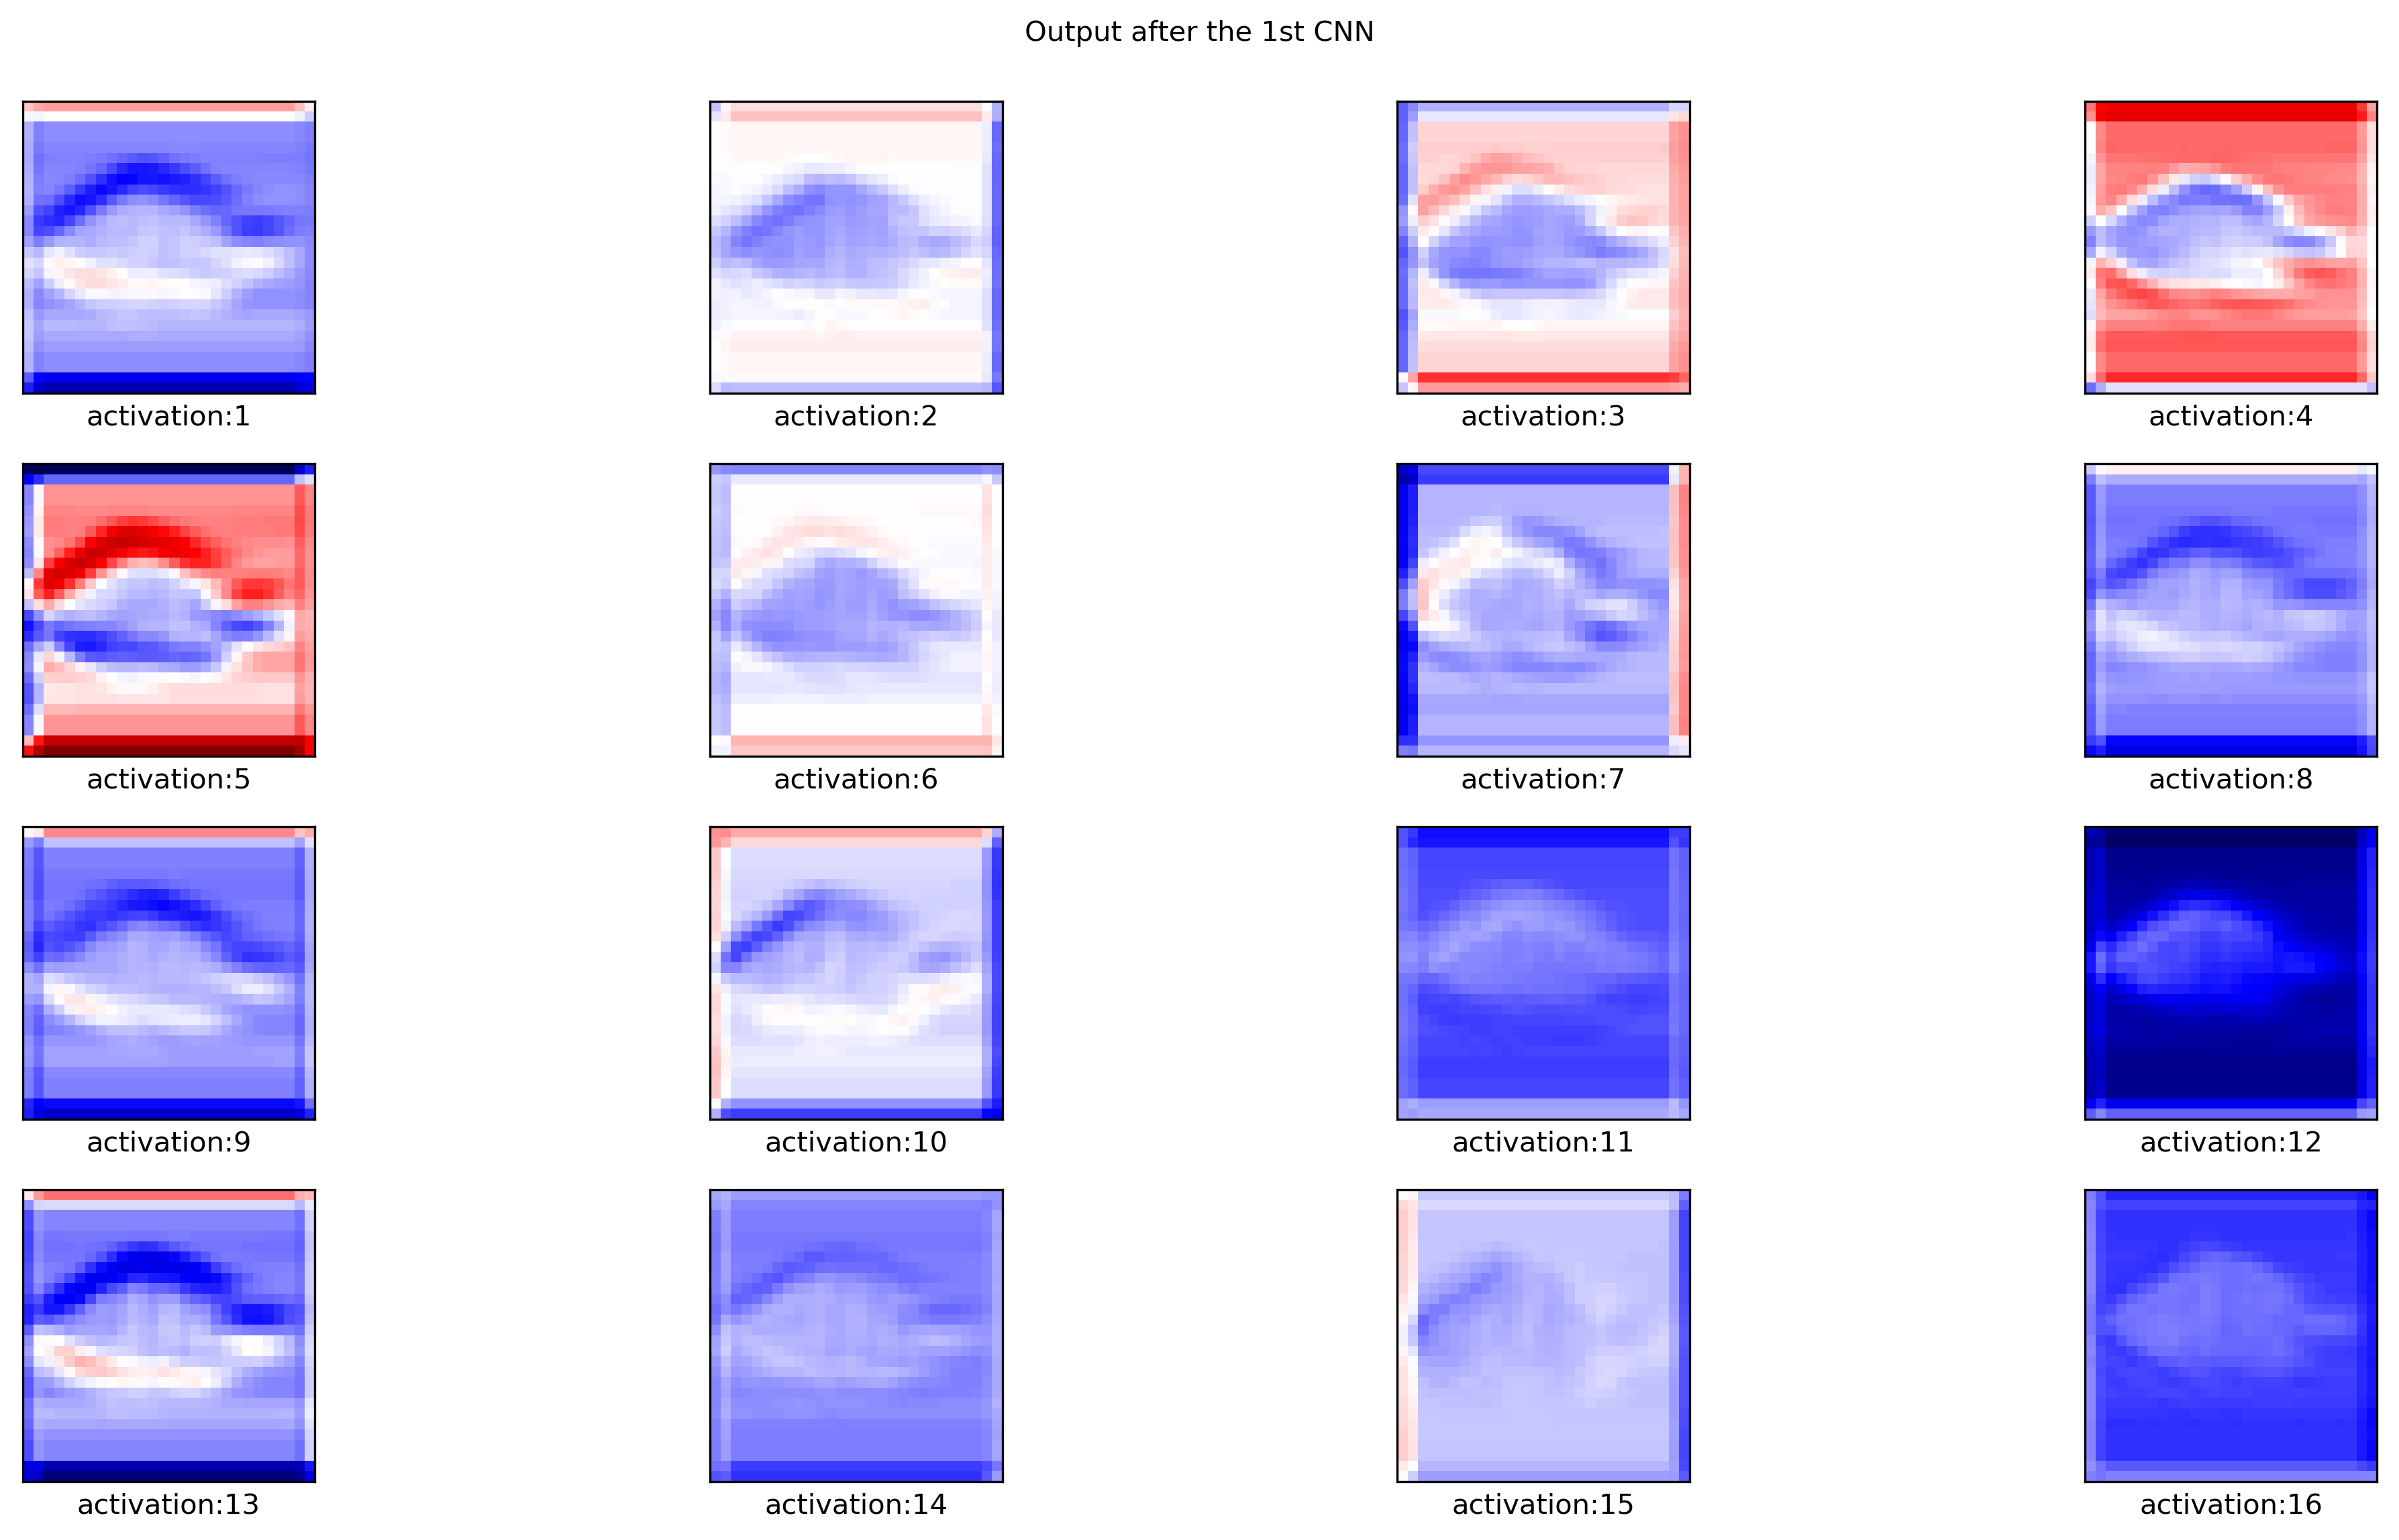

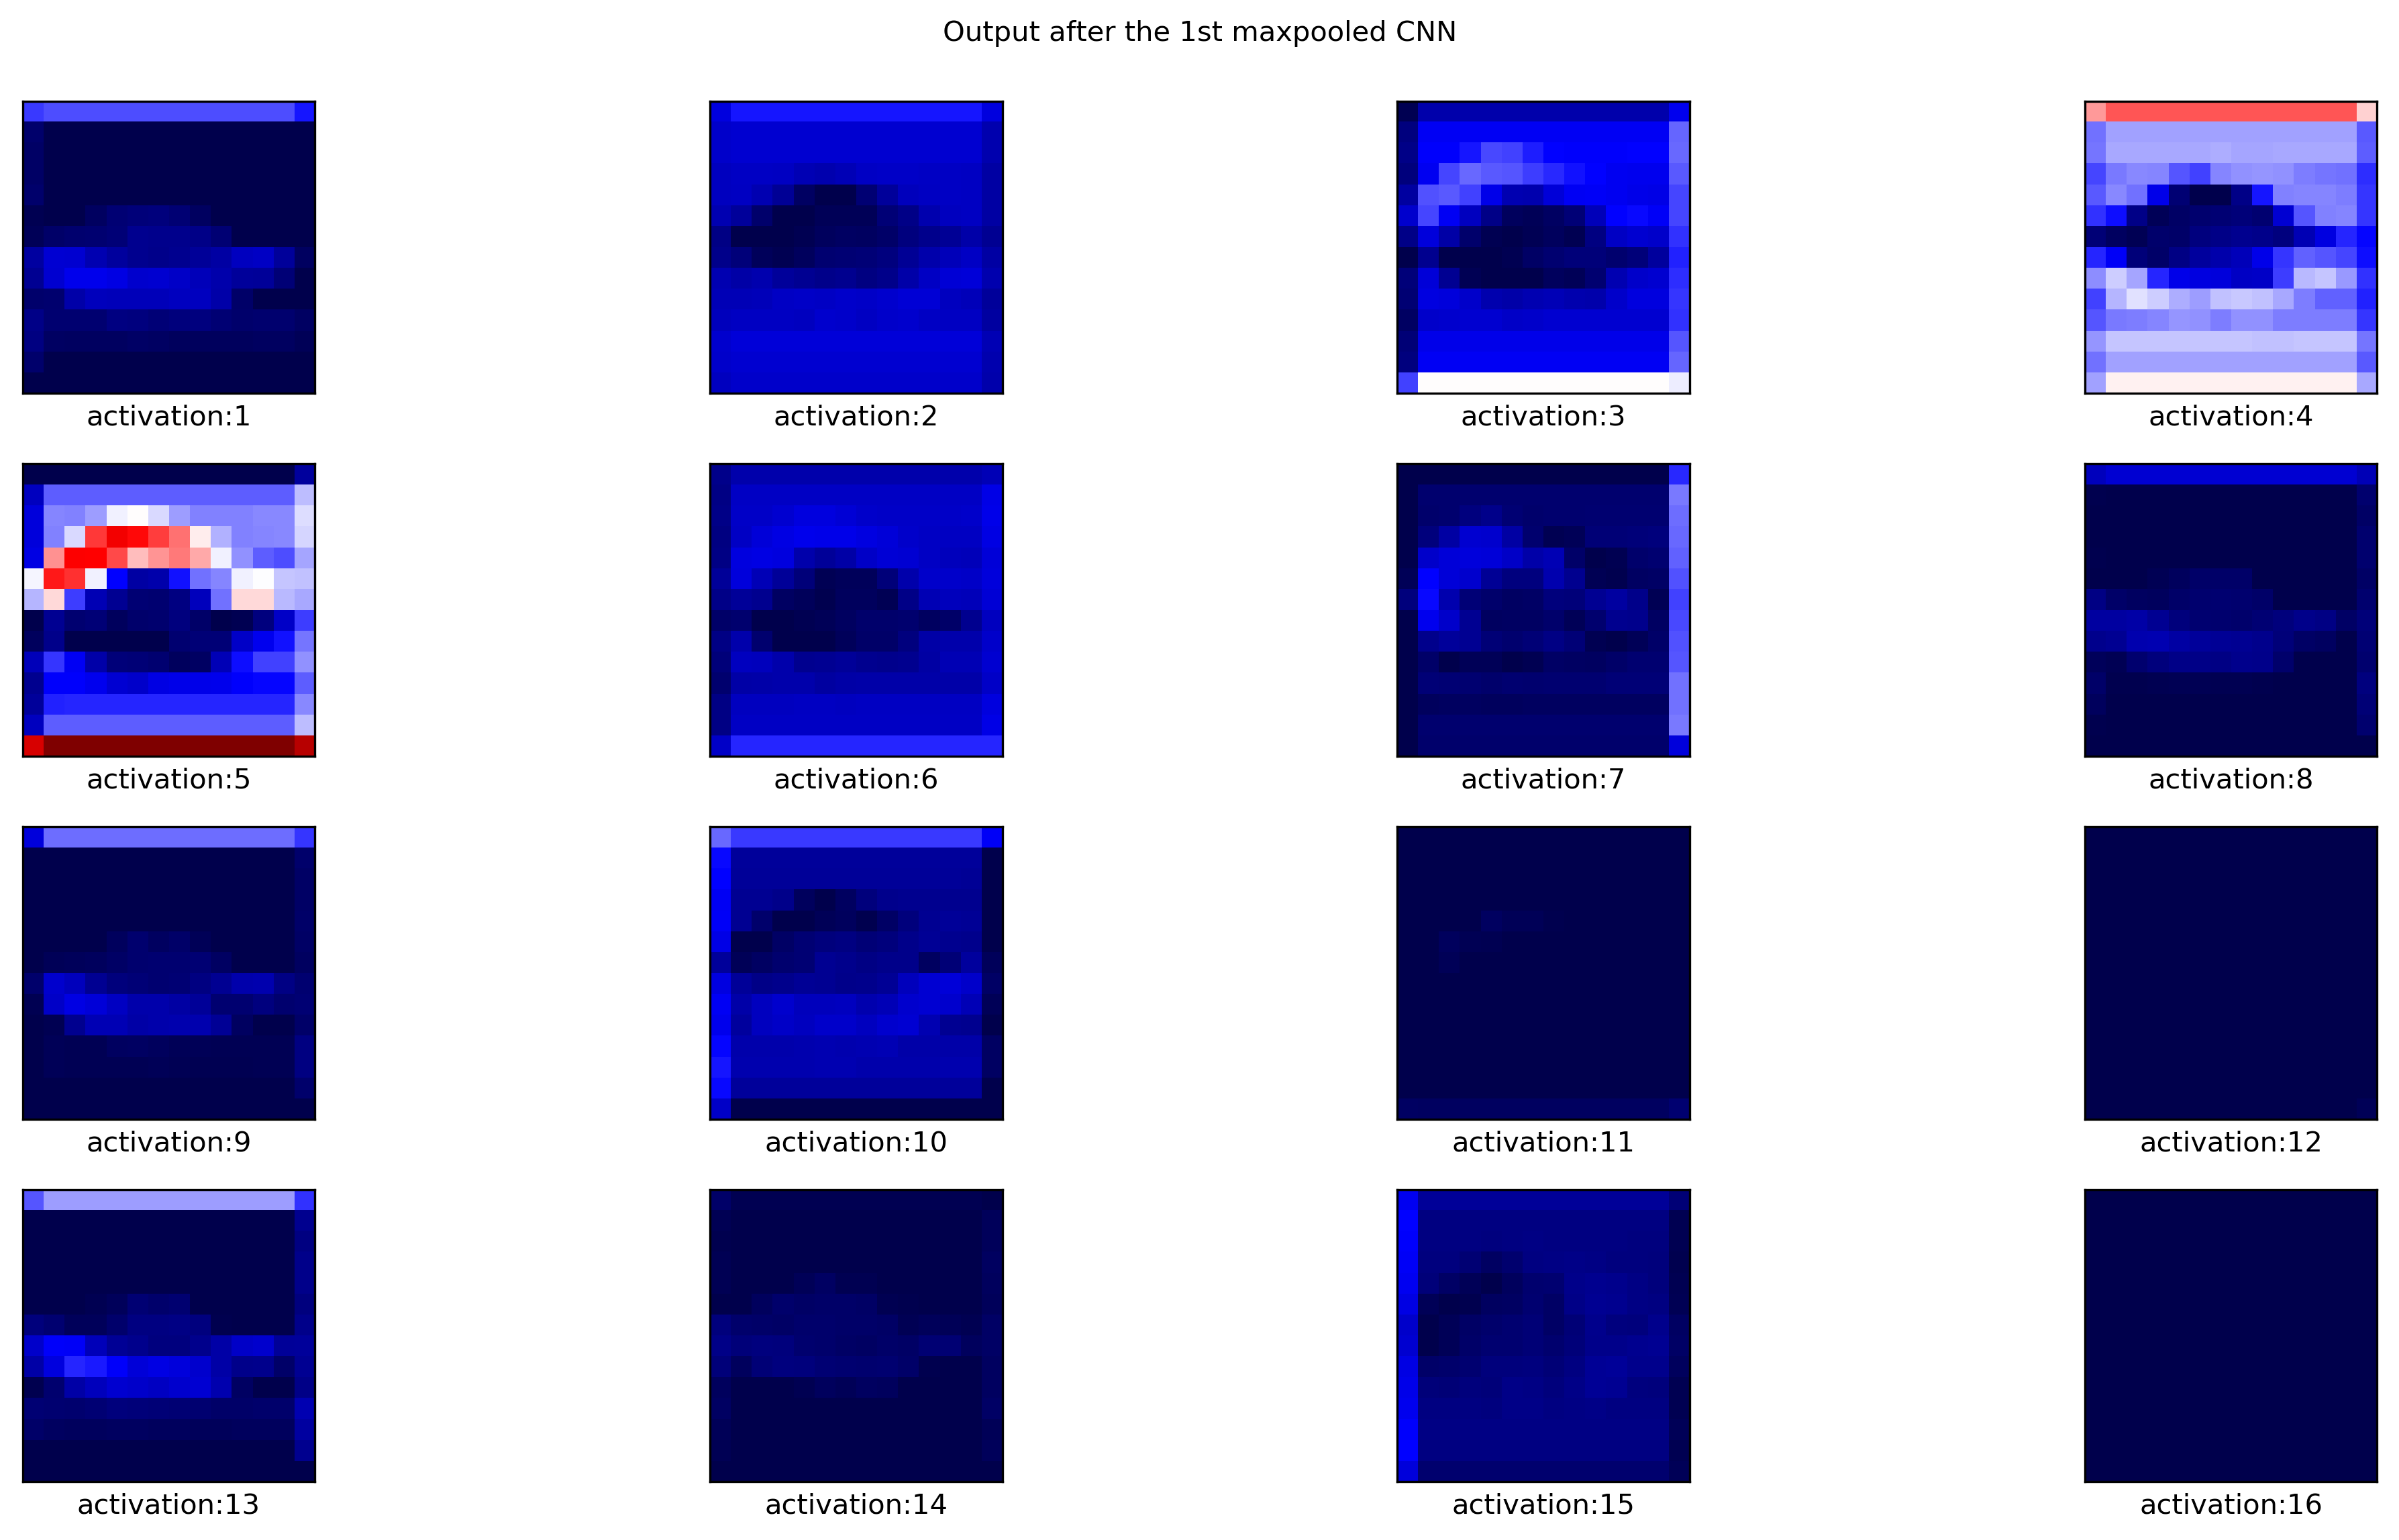

In [11]:
# Which example you want to plot for?
exampleId = 0

inpt, cnn_outputs, relu_outputs, maxpool_outputs, flattened_outputs, out = model.activations(dataset[exampleId]['image'].view(1, n_channels, imgH, imgH))
PlotNetwork.plot_activations(cnn_outputs[0], 4, "Output after the 1st CNN")
PlotNetwork.plot_activations(maxpool_outputs[0], 4, "Output after the 1st maxpooled CNN")

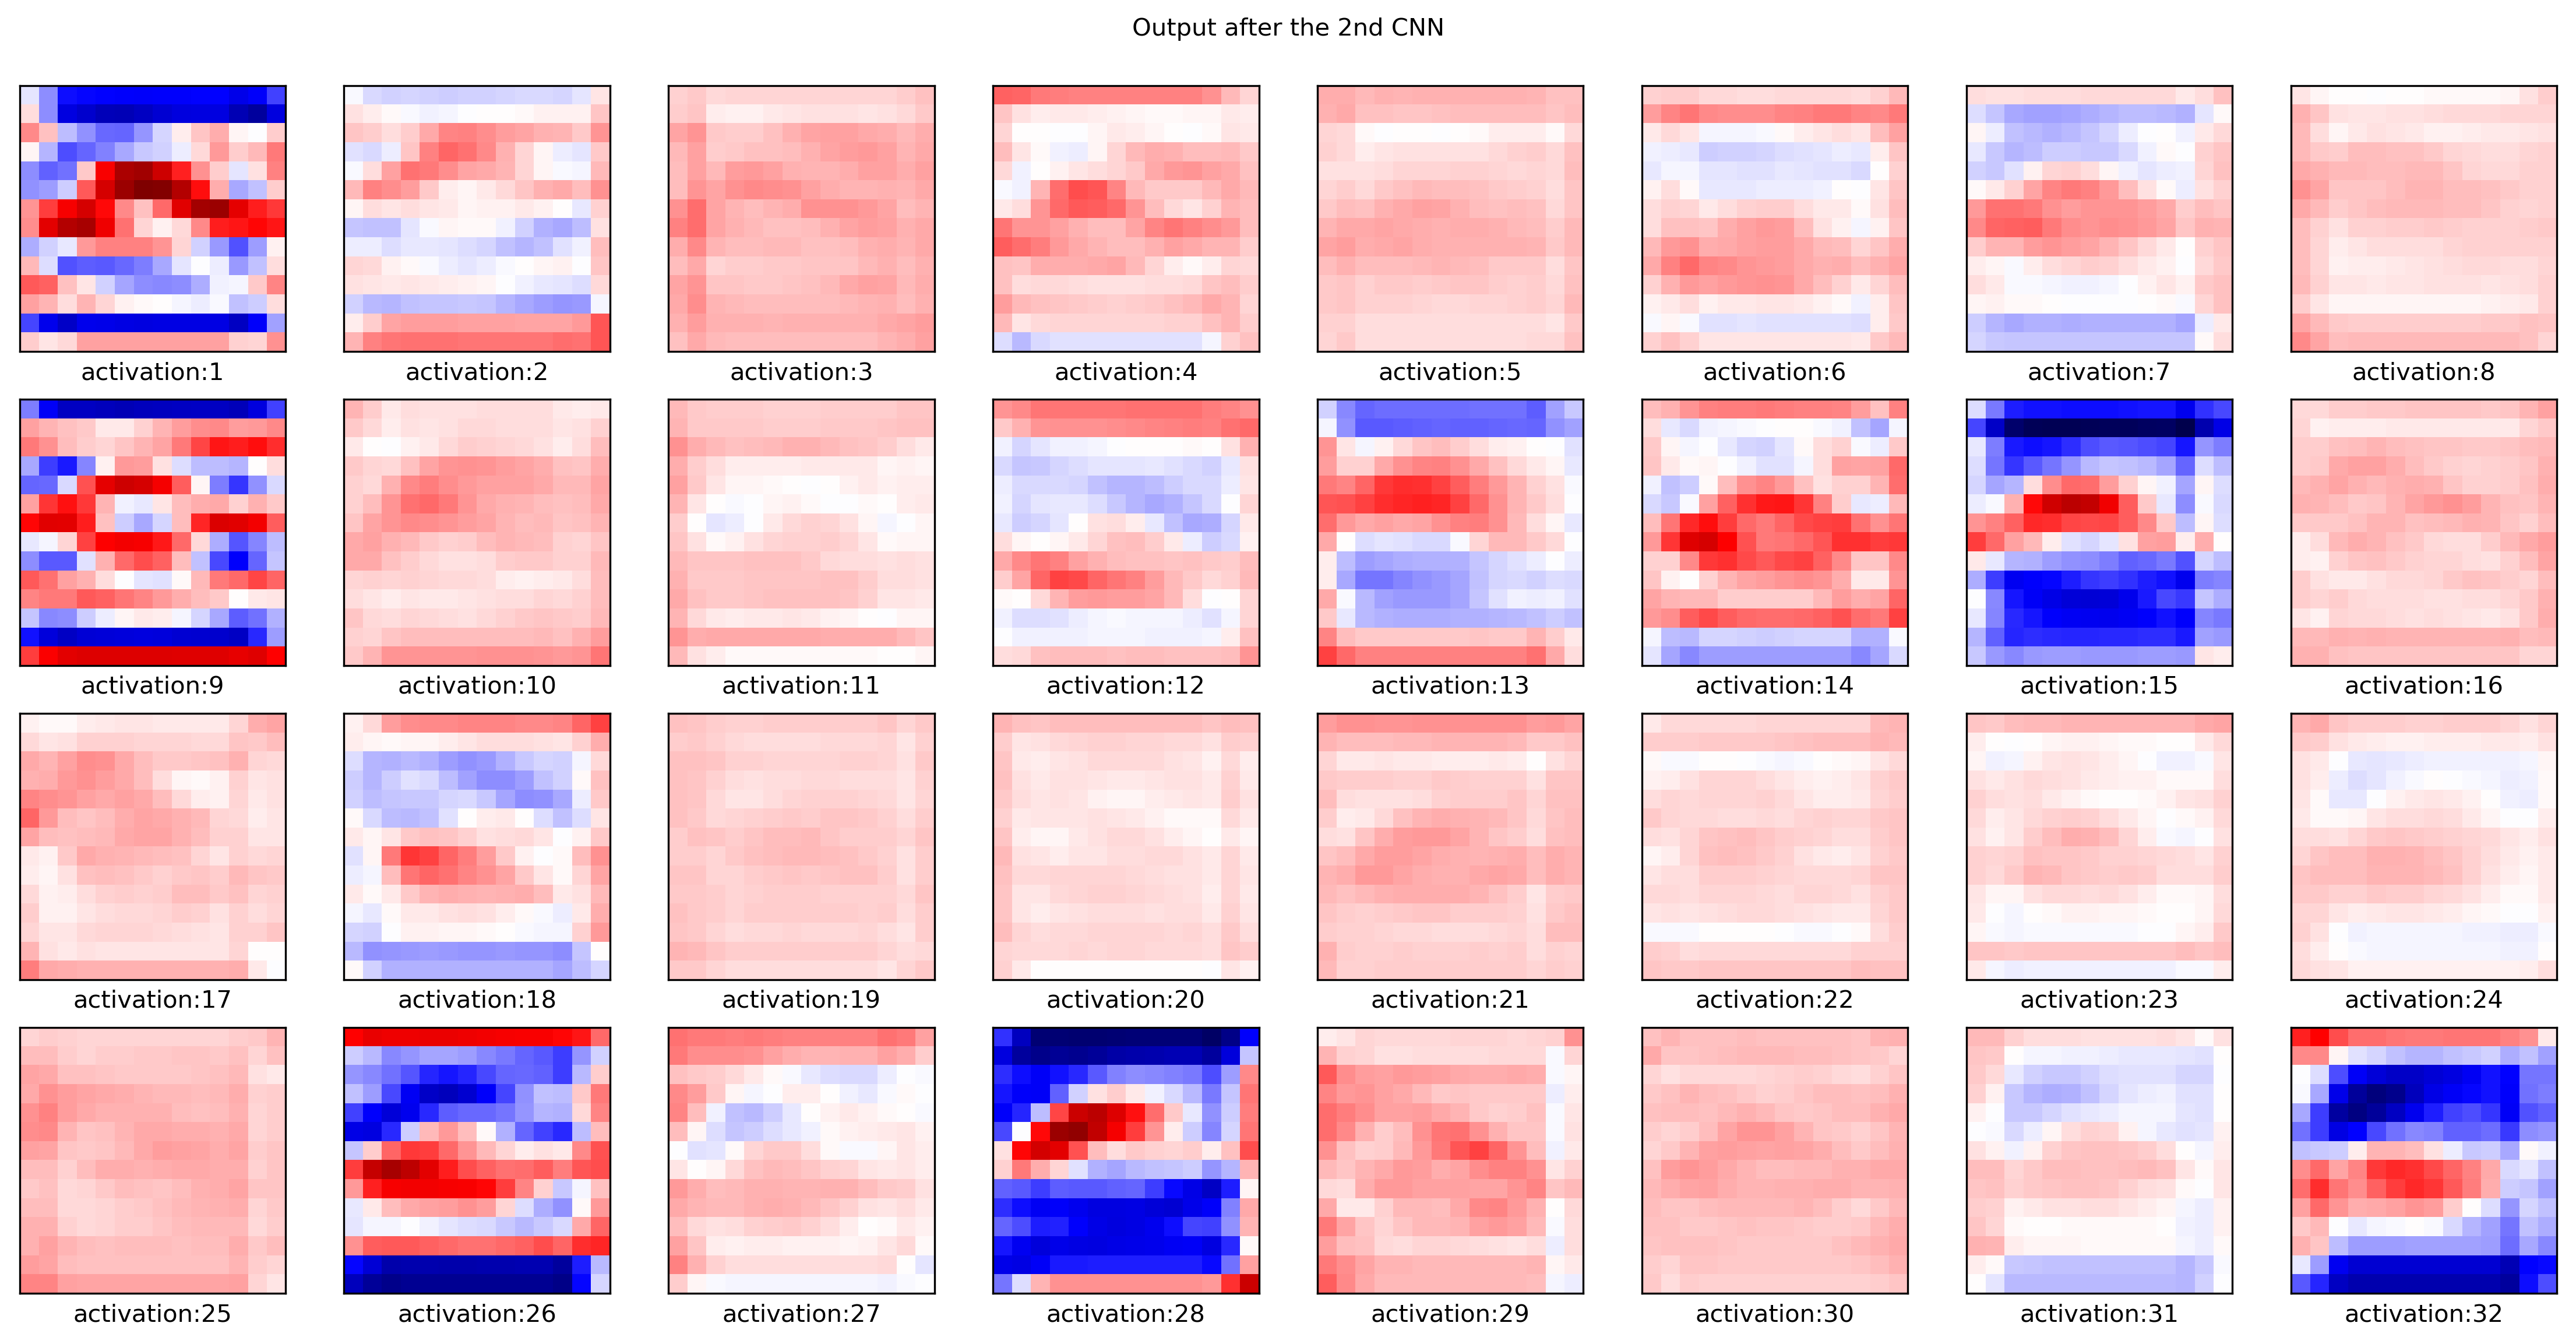

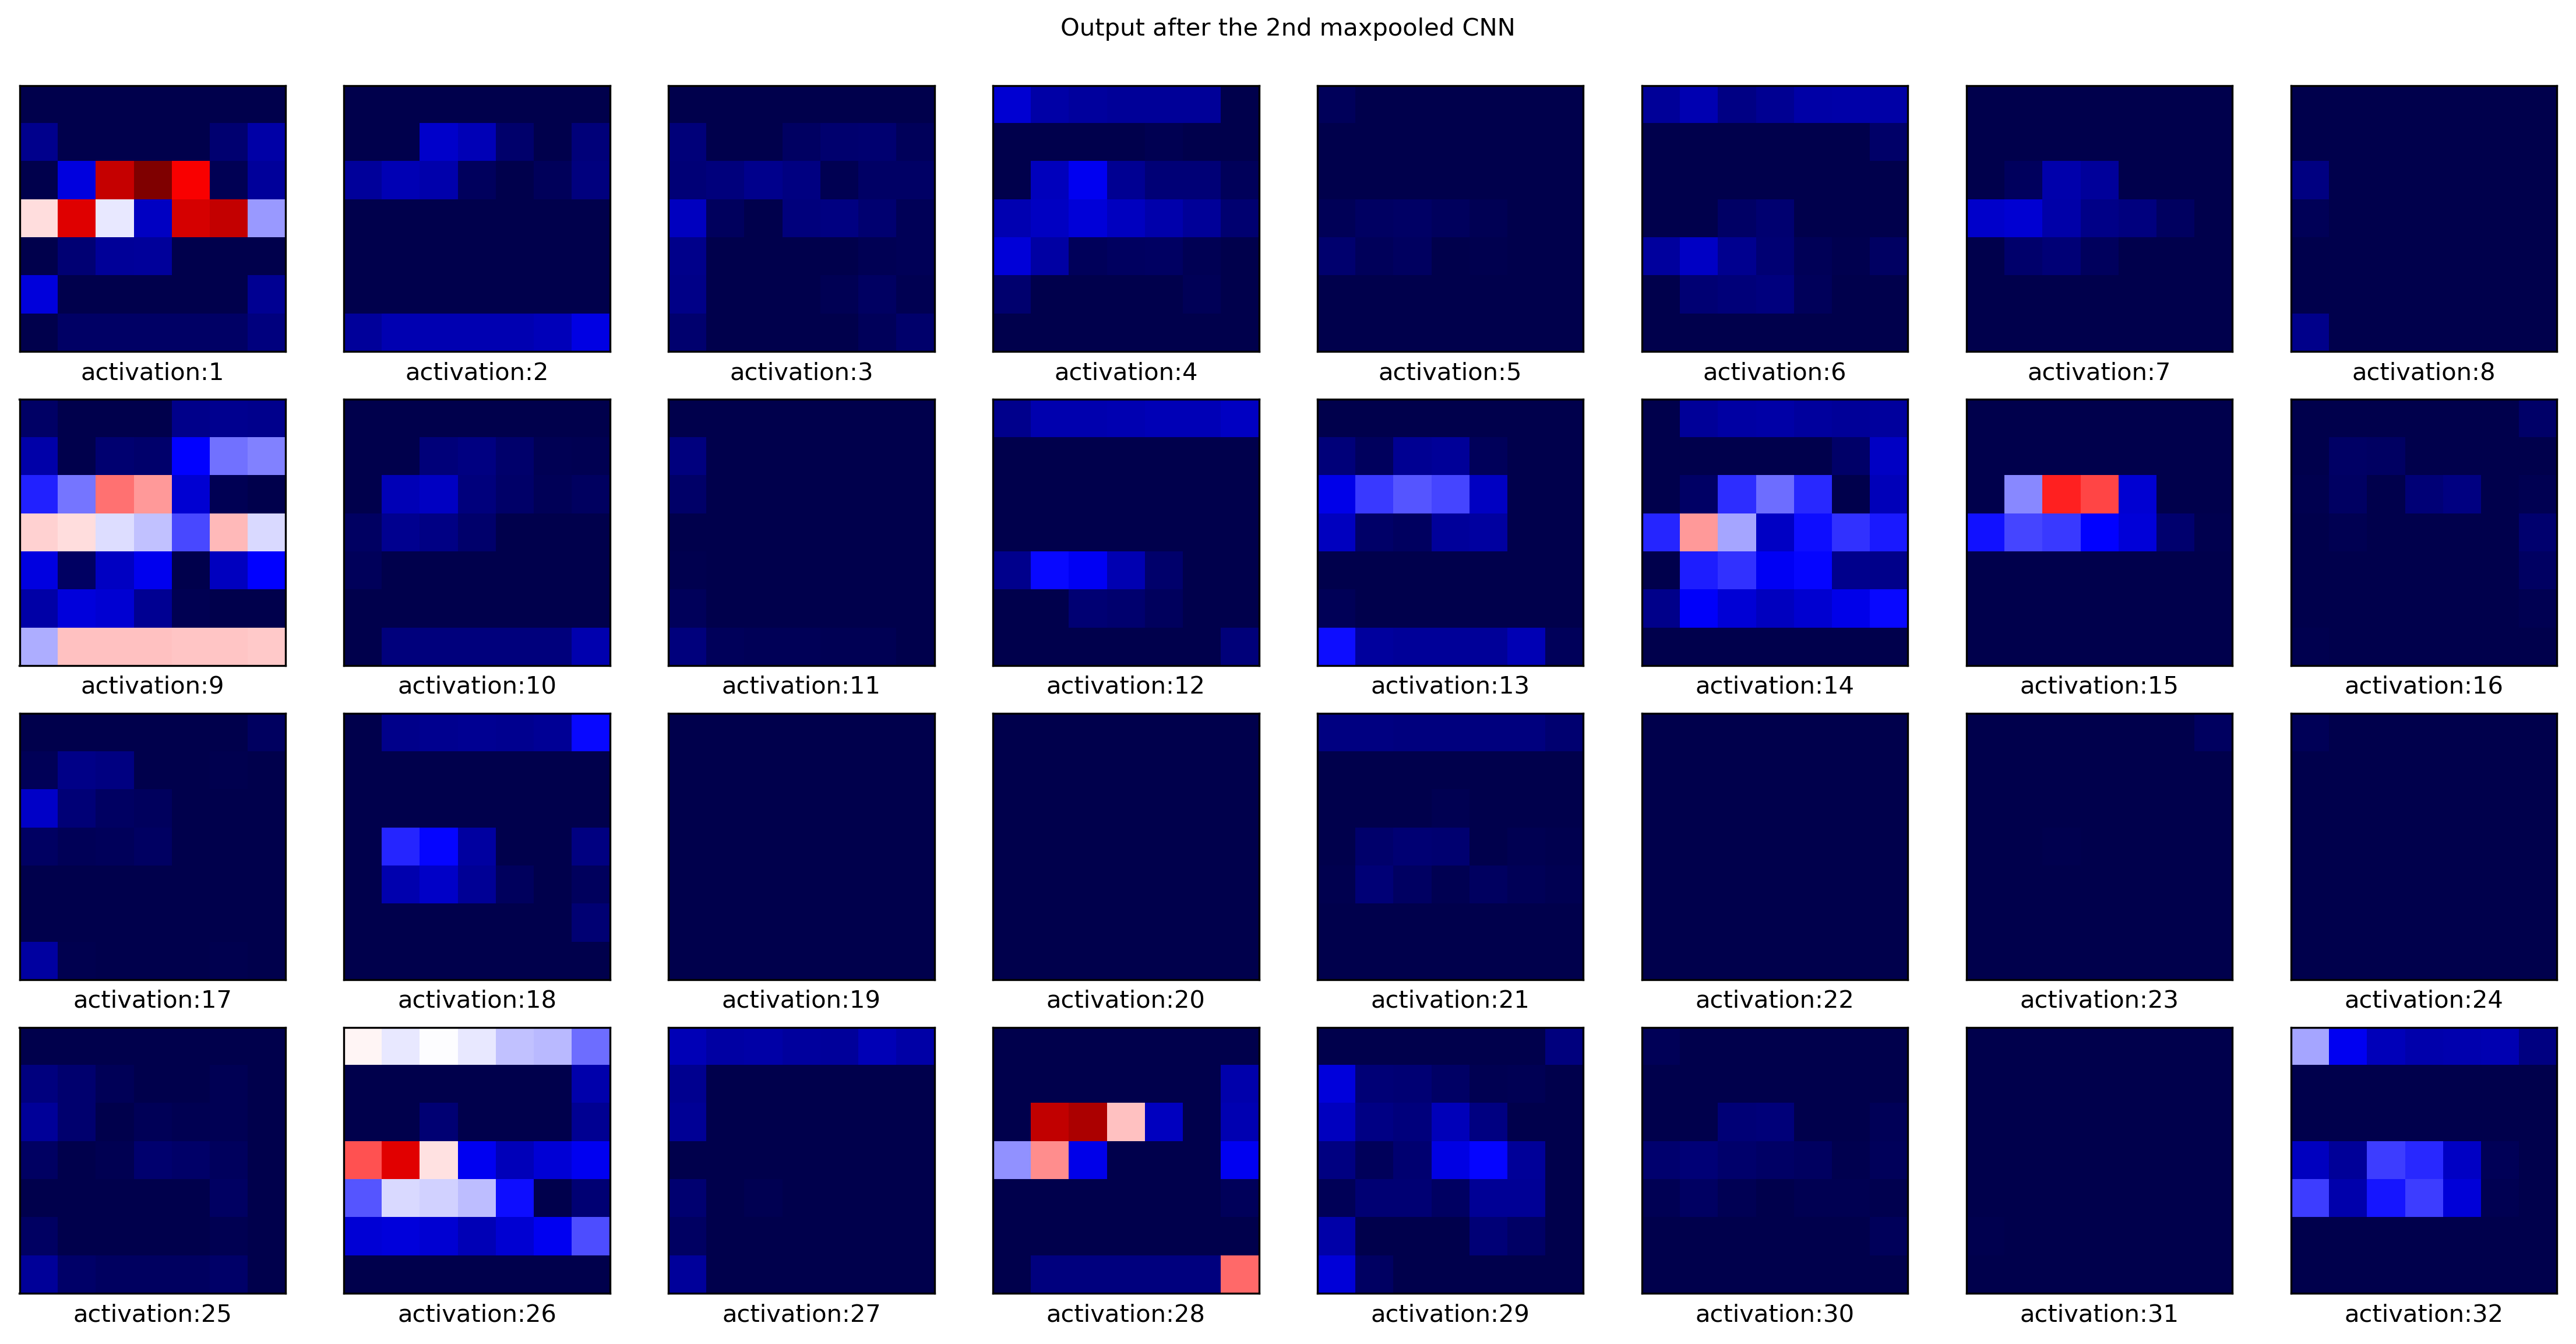

In [12]:
PlotNetwork.plot_activations(cnn_outputs[1], 4, "Output after the 2nd CNN")
PlotNetwork.plot_activations(maxpool_outputs[1], 4, "Output after the 2nd maxpooled CNN")

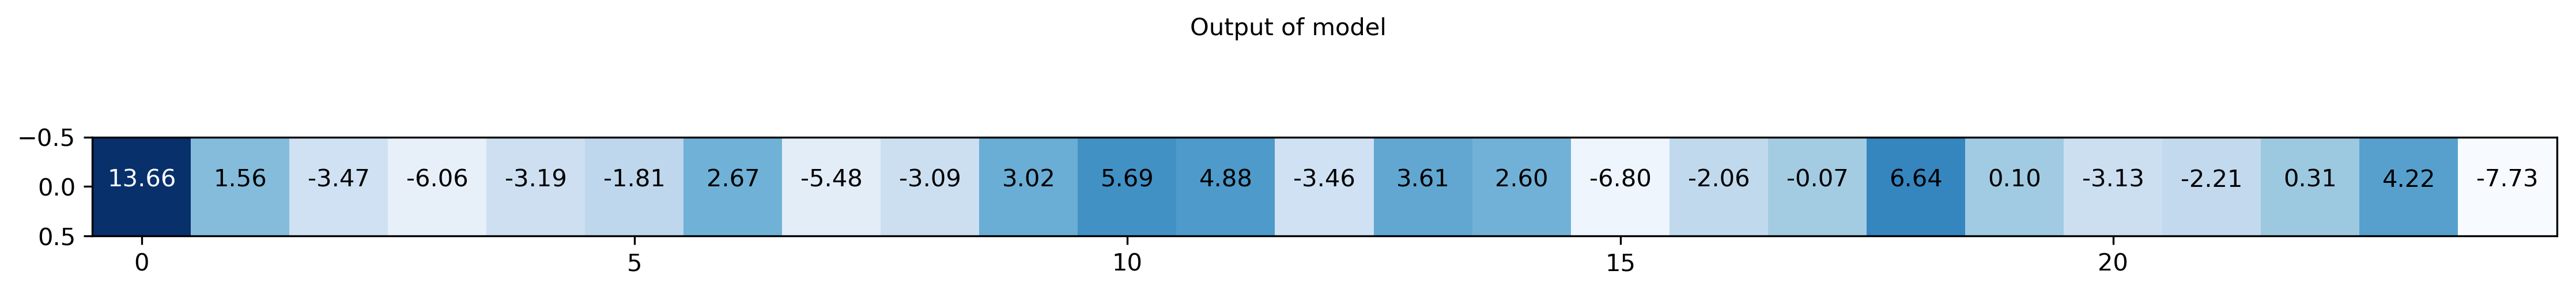

In [13]:
PlotNetwork.plot_activations(out, 25, "Output of model")

Least confused classes

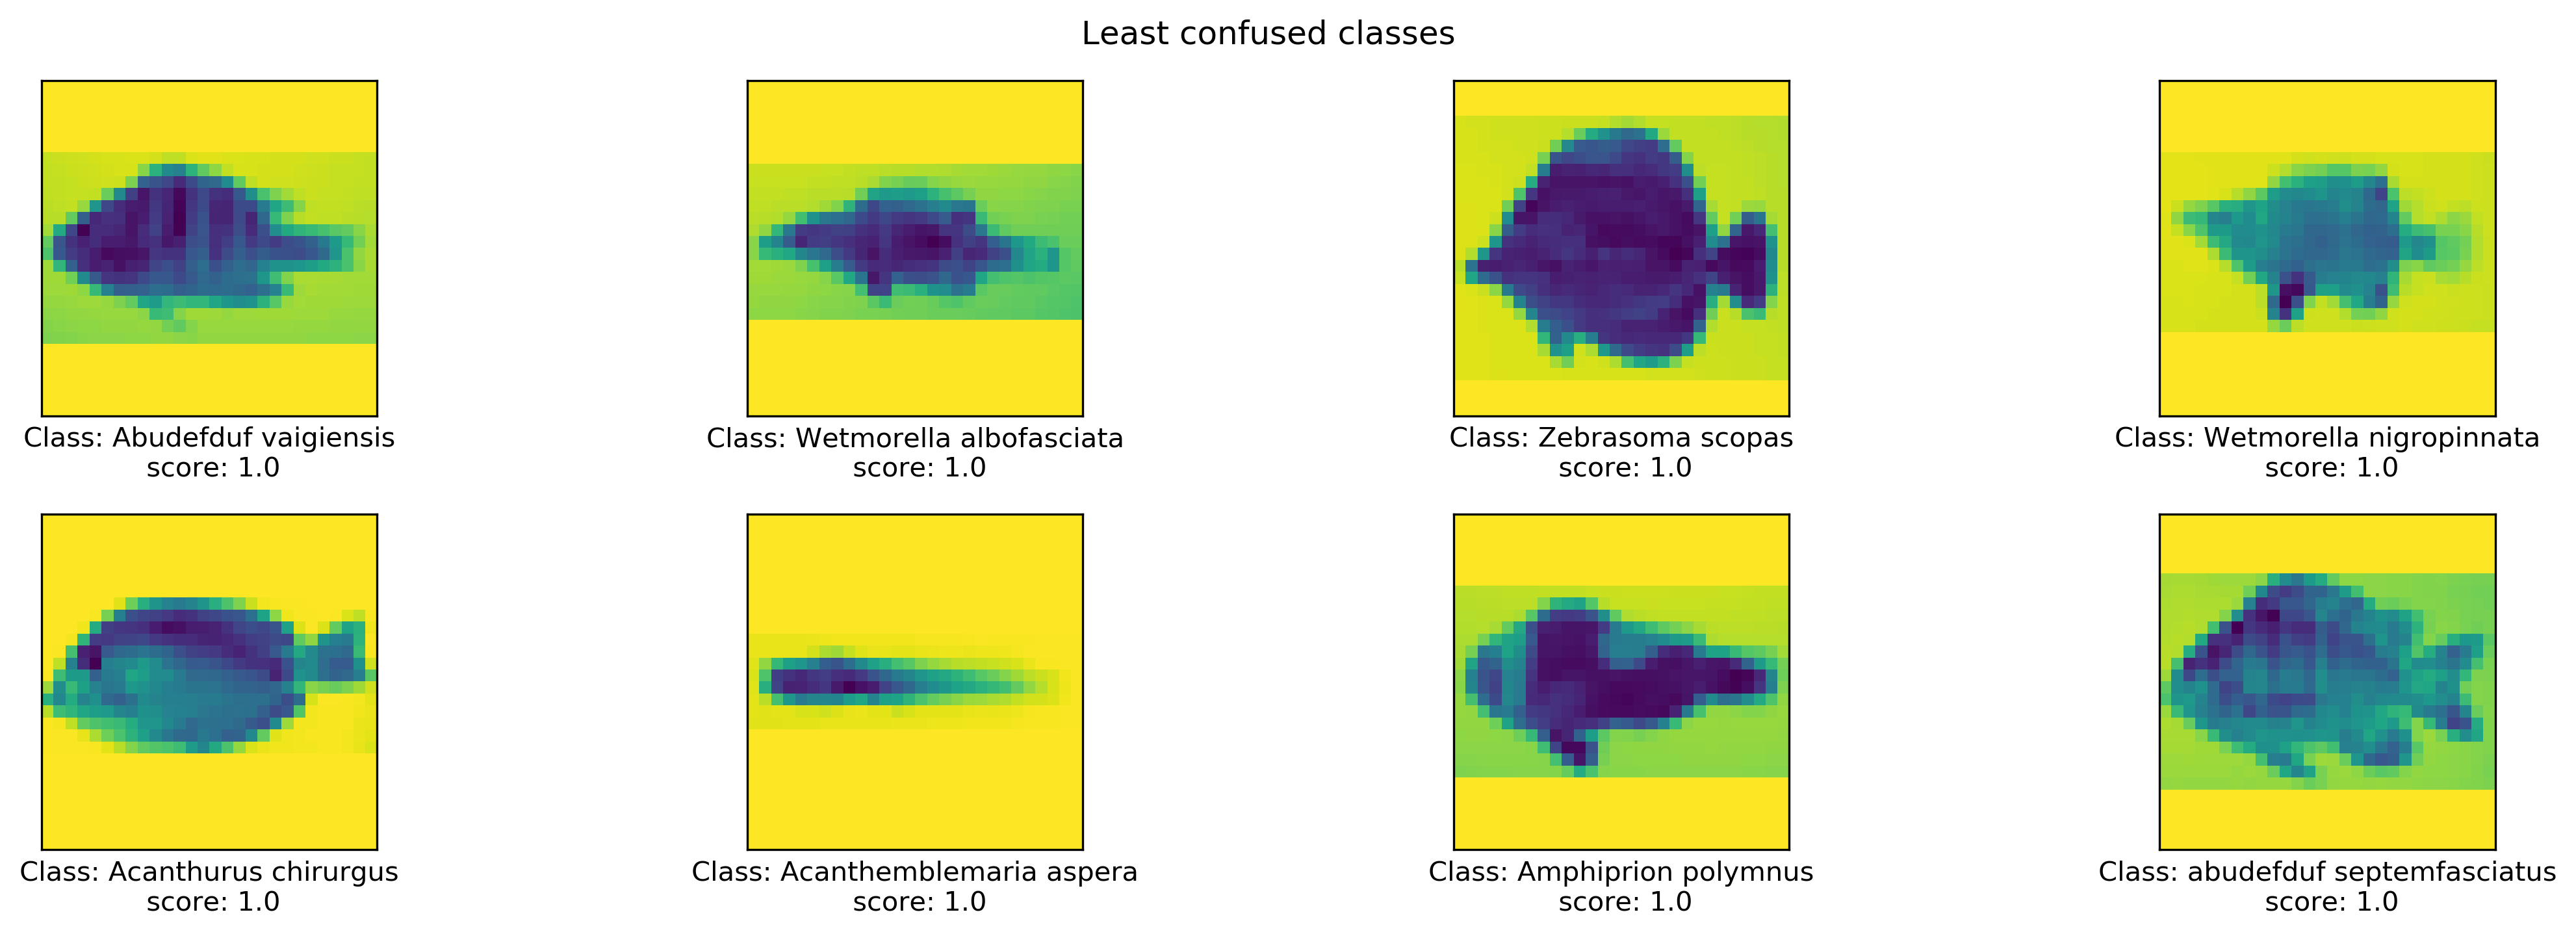

In [17]:
import numpy as np
import math

# From the confusion matrix, find the diagonal entries that have high value.
SuccessThreshold = 0.8

cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
diagIndices = di = np.diag_indices(cm.shape[0])
conf_mat_diagValues = cm[diagIndices]

goodMatches = [i for i,v in enumerate(conf_mat_diagValues) if v >= SuccessThreshold]
goodMatches_count = len(goodMatches)

# Plot
number_per_row = 4
n_rows = math.ceil(goodMatches_count/number_per_row)
fig, axes = plt.subplots(n_rows, number_per_row, figsize=(15, 2.5*n_rows), dpi= 300)
out_index = 0
in_index = 0
for i, ax in enumerate(axes.flat):
    if i < goodMatches_count:
        index = goodMatches[i]
        speciesName = dataset.getSpeciesOfIndex(index)
        ax.set_xlabel("Class: {0}\n score: {1}".format(speciesName, conf_mat_diagValues[index]))

        # Plot the image.
        speciesExamples = dataset.getSpeciesIndices(speciesName)
        speciesExample = dataset[speciesExamples[0]]['image'].squeeze()

        if n_channels != 1:
            speciesExample = speciesExample.permute(1, 2, 0)
        ax.imshow(speciesExample.cpu().detach().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        break
        
fig.suptitle("Least confused classes")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()
fig.savefig(savedModelName+"/LestConfusedClasses.png")
    
    

Most confused classes

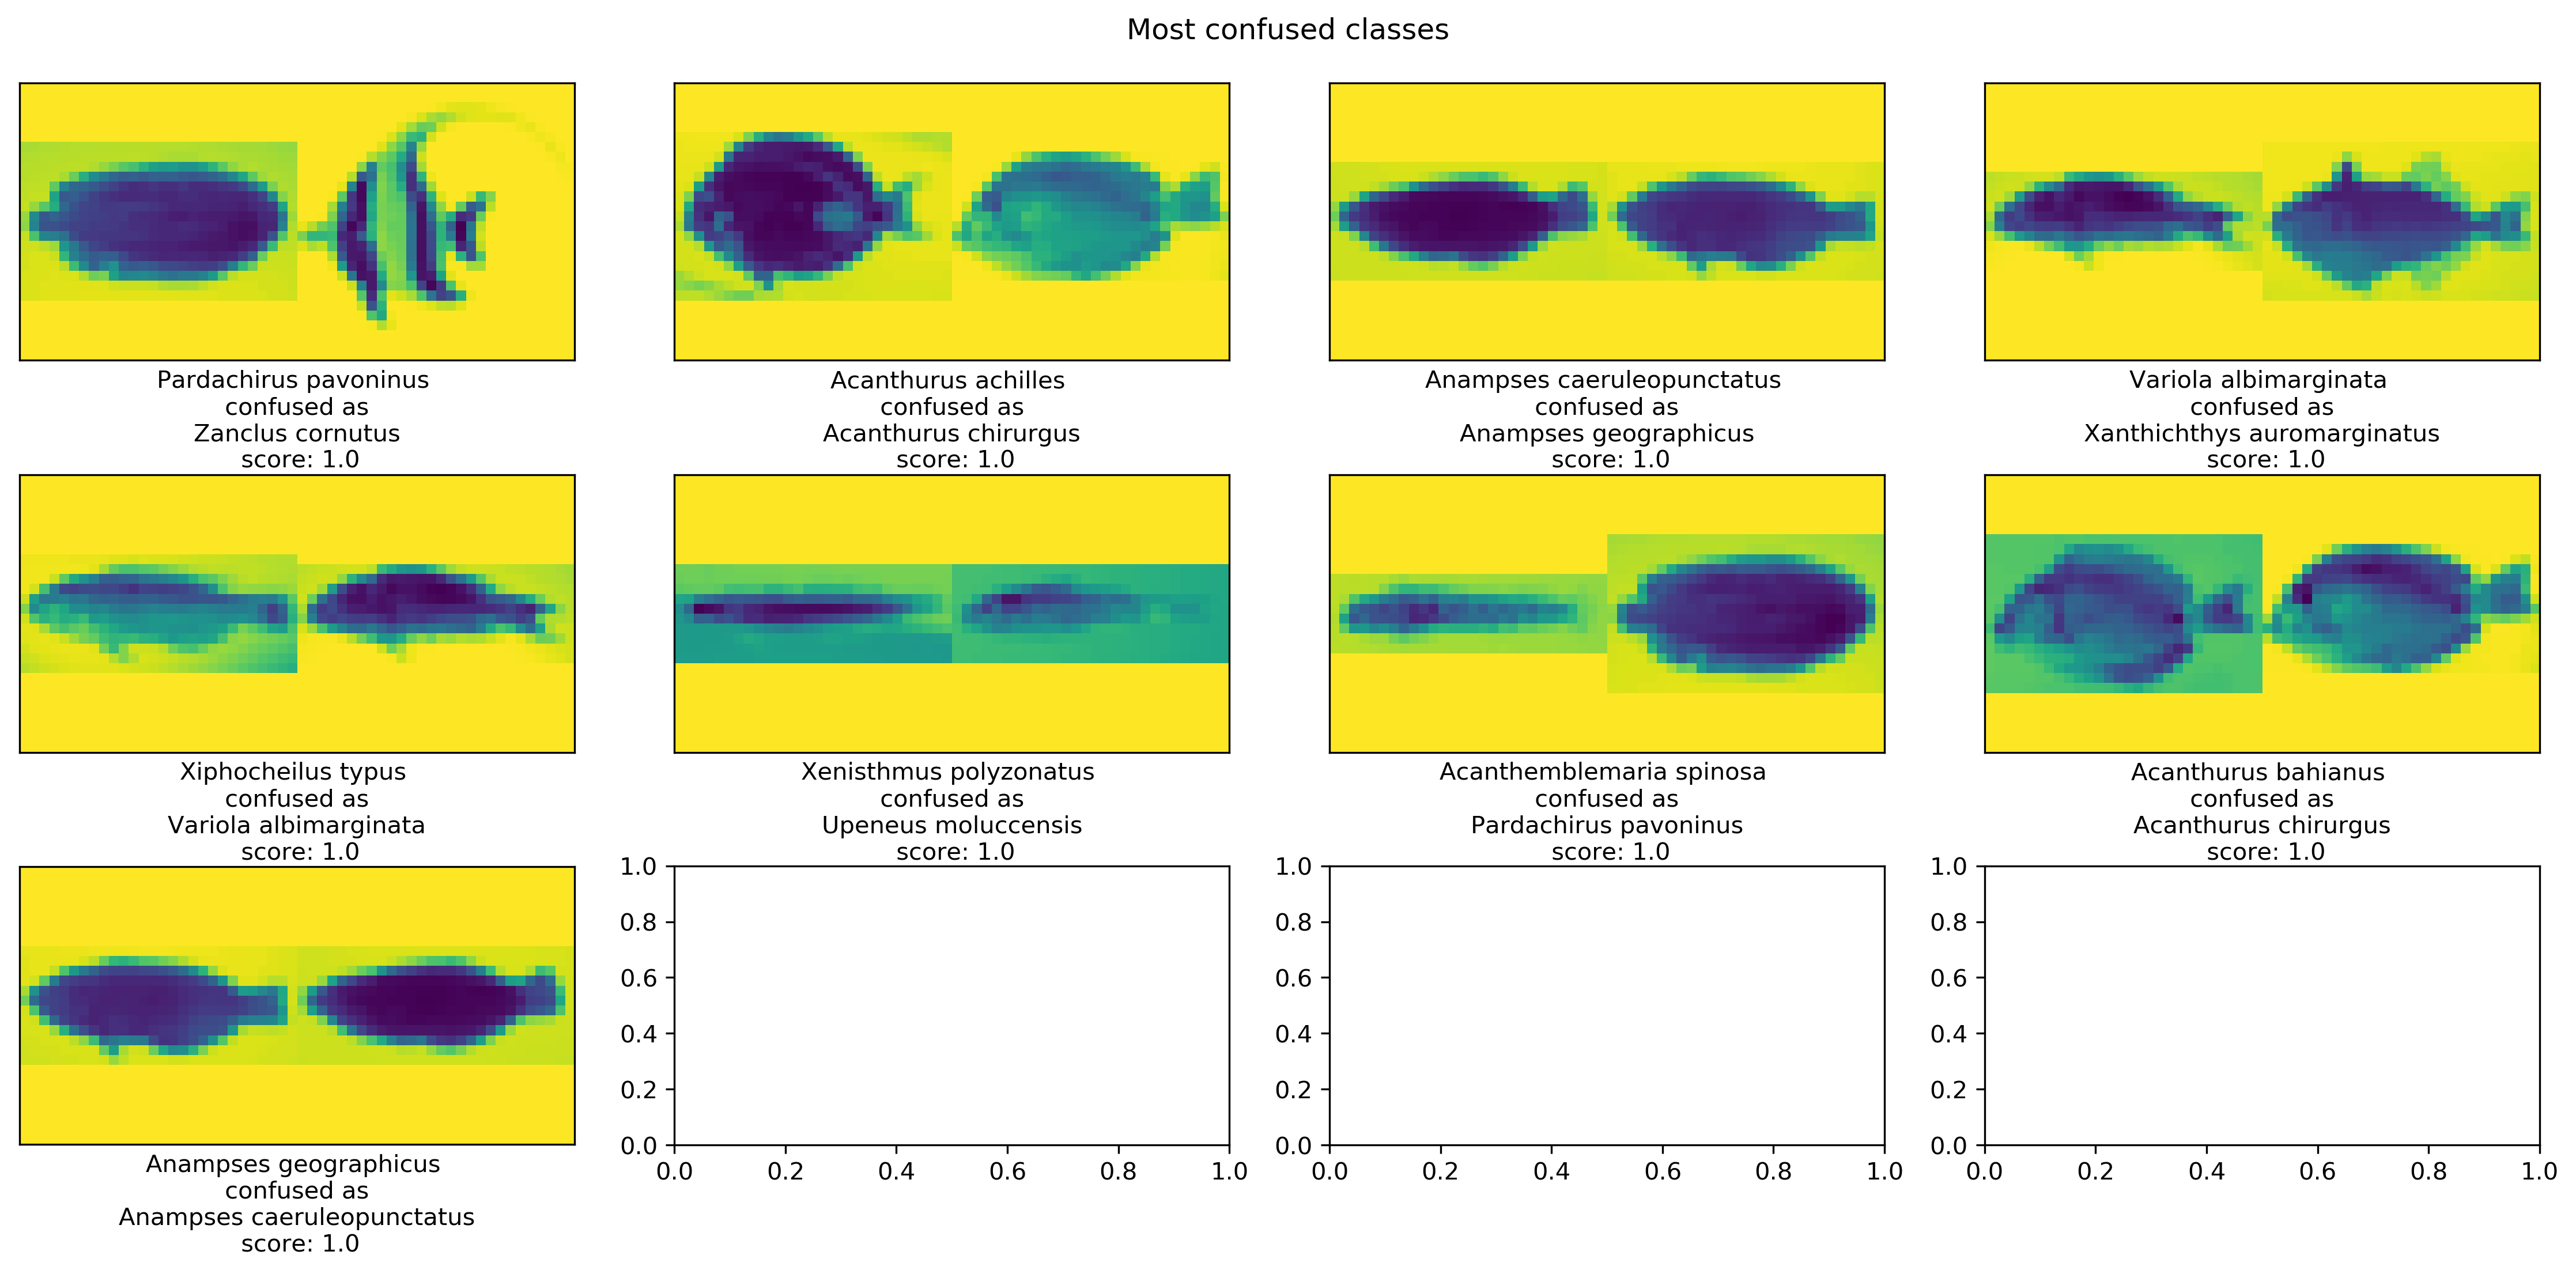

In [20]:
# From the confusion matrix, find the diagonal entries that have high value.
ConfusionThreshold = 0.8

cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
diagIndices = di = np.diag_indices(cm.shape[0])

goodMatches = [(x, y) for (x, y), v in np.ndenumerate(cm) if v >= ConfusionThreshold and x != y]
goodMatches_count = len(goodMatches)

number_per_row = 4
n_rows = math.ceil(goodMatches_count/number_per_row)
fig, axes = plt.subplots(n_rows, number_per_row, figsize=(15, 2.5*n_rows), dpi= 300)
out_index = 0
in_index = 0
for i, ax in enumerate(axes.flat):
    if i < goodMatches_count:
        (x, y) = goodMatches[i]
        speciesNameConfused = dataset.getSpeciesOfIndex(x)
        speciesNameConfusedAs = dataset.getSpeciesOfIndex(y)
        ax.set_xlabel("{0} \n confused as \n{1}\n score: {2}".format(speciesNameConfused, speciesNameConfusedAs, cm[x][y]))

        # Plot the image.
        confusedSpeciesExamples = dataset.getSpeciesIndices(speciesNameConfused)
        confusedSpeciesExample = dataset[confusedSpeciesExamples[0]]['image'].squeeze()
        confusedAsSpeciesExamples = dataset.getSpeciesIndices(speciesNameConfusedAs)
        confusedAsSpeciesExample = dataset[confusedAsSpeciesExamples[0]]['image'].squeeze()

        channel = 2 if n_channels != 1 else 1
        stitchedImage = torch.cat((confusedSpeciesExample, confusedAsSpeciesExample), channel)
        
        if n_channels != 1:
            stitchedImage = stitchedImage.permute(1, 2, 0)
        ax.imshow(stitchedImage.cpu().detach().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        break
        
fig.suptitle("Most confused classes")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()
fig.savefig(savedModelName+"/MostConfusedClasses.png")